In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x** 2 - 4*x + 5

In [3]:
f(4.0)

37.0

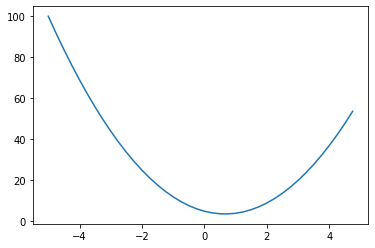

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"



    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other



    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)



    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only int/float"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out



    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out



    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)  /  (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += 1 - t**2 * out.grad
        out._backward = _backward

        return out



    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        self.grad = 1.0
        build_topo(self)
        for i in topo[-1::-1]:
            i._backward()
        

In [9]:
a= Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
L

Value(data=-8.0)

In [11]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
L.grad = 1.0
e.grad = f.data * L.grad
f.grad = e.data * L.grad
d.grad = e.grad * 1
c.grad = e.grad * 1
b.grad = d.grad * a.data
a.grad = d.grad * b.data

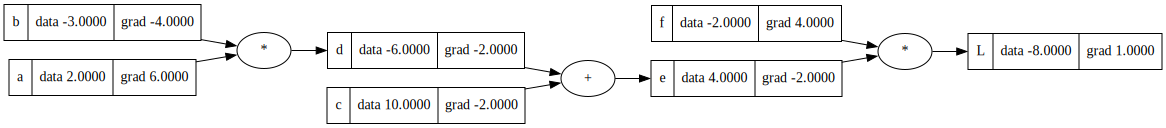

In [13]:
draw_dot(L)

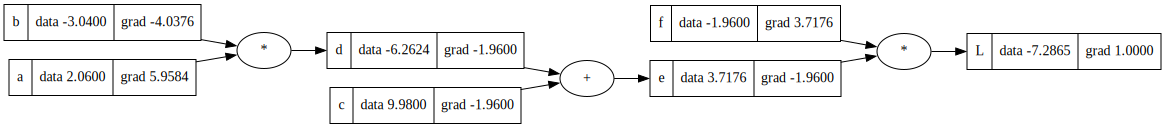

In [14]:
optimize_step = 0.01

a.data += optimize_step * a.grad
b.data += optimize_step * b.grad
c.data += optimize_step * c.grad
f.data += optimize_step * f.grad

d.data = (a*b).data
e.data = (d+c).data
L.data = (e*f).data

L.grad = 1.0
e.grad = f.data * L.grad
f.grad = e.data * L.grad
d.grad = e.grad * 1
c.grad = e.grad * 1
b.grad = d.grad * a.data
a.grad = d.grad * b.data

draw_dot(L)

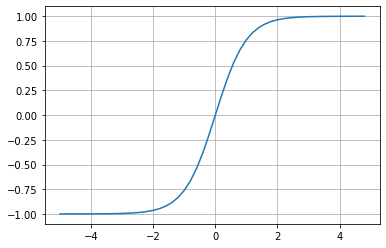

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [16]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.5, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [17]:
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

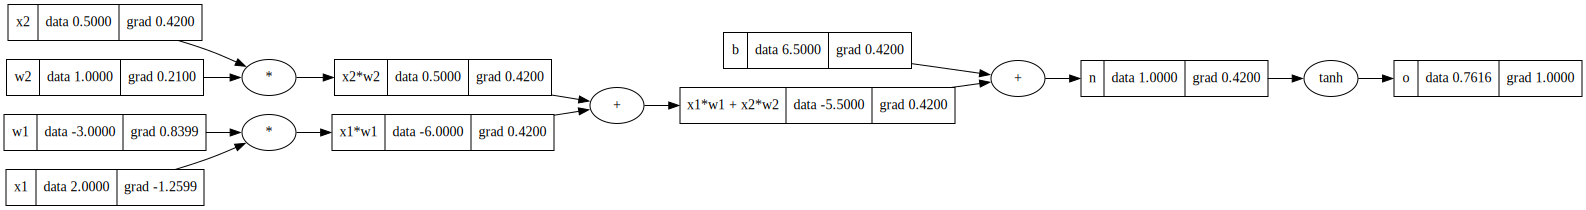

In [18]:
draw_dot(o)

In [19]:
optimize_step = 0.01

w1.data += optimize_step * w1.grad
w2.data += optimize_step * w2.grad

In [20]:
for i in range(100):
    #Forward Pass
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'

    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

    n = x1w1x2w2 + b; n.label = 'n'

    o = n.tanh()

    #Back Propogation
    o.grad = 1.0
    n.grad = 1 - o.data**2
    b.grad = n.grad
    x1w1x2w2.grad = n.grad
    x1w1.grad = n.grad #x1w1x2w2.grad
    x2w2.grad = n.grad #x1w1x2w2.grad
    x1.grad = w1.data * n.grad #x1w1.grad
    w1.grad = x1.data * n.grad #x1w1.grad
    x2.grad = w2.data * n.grad #x2w2.grad
    w2.grad = x2.data * n.grad #x2w2.grad

    #Update Weights
    optimize_step = 0.01

    w1.data += optimize_step * w1.grad
    w2.data += optimize_step * w2.grad

    

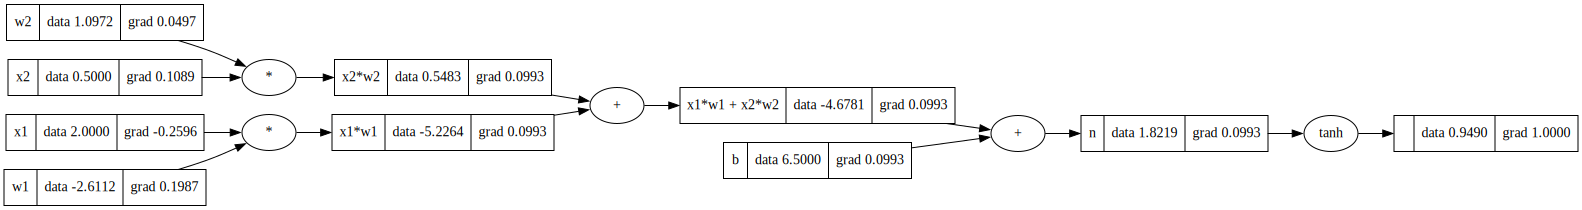

In [21]:
draw_dot(o)

In [22]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.5, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [23]:
o.grad = 1.0

o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


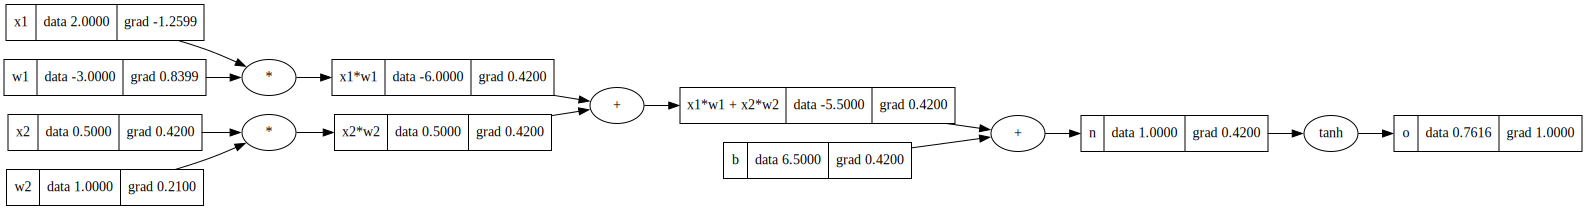

In [24]:
draw_dot(o)

In [25]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.5, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [26]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        topo.append(v)
        for child in v._prev:
            build_topo(child)

build_topo(o)
topo

[Value(data=0.7615941559557649),
 Value(data=1.0),
 Value(data=-5.5),
 Value(data=0.5),
 Value(data=0.5),
 Value(data=1.0),
 Value(data=-6.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=6.5)]

In [27]:
o.grad = 1.0
for i in topo:
    i._backward()


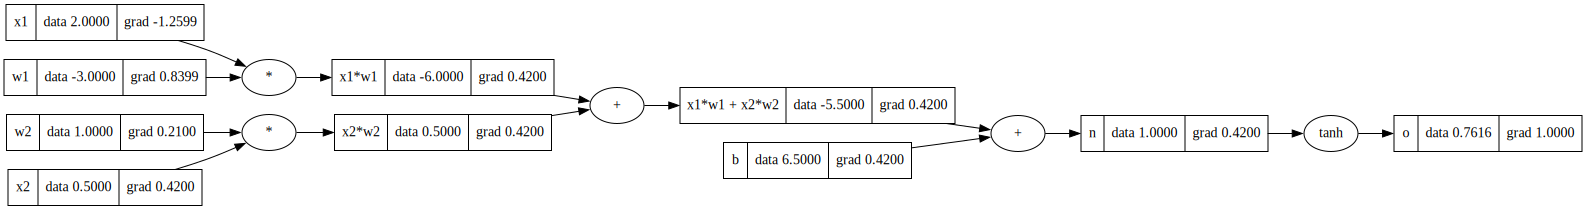

In [28]:
draw_dot(o)

In [29]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.5, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [30]:
o.backward()

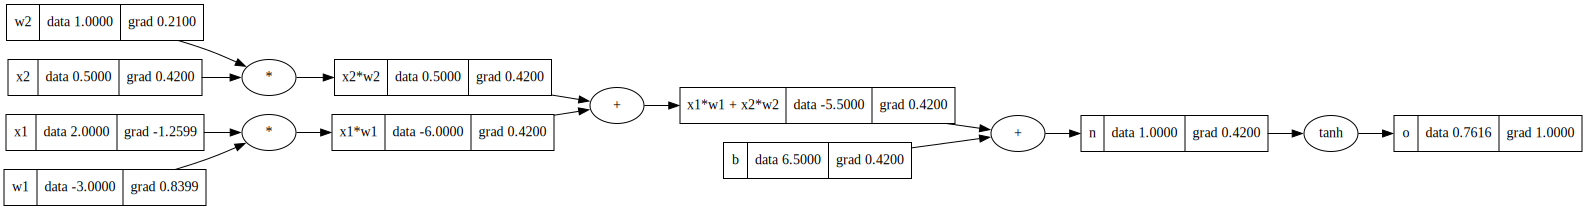

In [31]:
draw_dot(o)

In [32]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.5, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#o = n.tanh(); o.label = 'o'

e2x = (2 * n).exp()
o = (e2x - 1) / (e2x + 1)

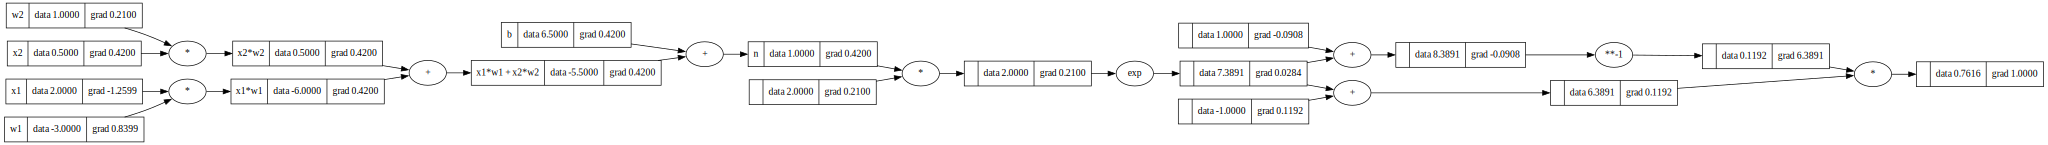

In [33]:
o.backward()
draw_dot(o)

In [34]:
import torch

In [35]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.5]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.5]).double()                ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('b', b.grad.item())

0.7615941559557649
-----
x1 -1.2599230248420783
w1 0.8399486832280523
x2 0.41997434161402614
w2 0.20998717080701307
b 0.41997434161402614
